In [1]:
import json
import os
import pickle
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plt.style.use("seaborn-muted")

In [3]:
with open("./output/new_to_old_map.json") as f:
    new_to_old_map = json.load(f)

old_to_new_map = {v: k for k, v in new_to_old_map.items()}

name_map = (
    gpd.read_file("./data/mpios/metropoli.shp")[["CVEGEO", "NOM_ZONA"]]
    .assign(
        NEW_CVE_ZONA=lambda x: x["CVEGEO"].map(old_to_new_map),
        NOM_ZONA=lambda x: x["NOM_ZONA"]
        .str.replace("Zona metropolitana de ", "")
        .str.replace("Metrópoli municipal de ", "")
        .str.strip(),
    )
    .dropna(subset=["NEW_CVE_ZONA"])
    .set_index("NEW_CVE_ZONA")["NOM_ZONA"]
    .to_dict()
)

In [4]:
segregation_path = Path(os.environ["SEGREGATION_PATH"])

In [ ]:
rows = {}
for path in (segregation_path / "results").glob("*.pkl"):
    with open(path, "rb") as f:
        rows[path.stem] = pickle.load(f)["H"].item()

df = (
    pd.Series(rows, name="H")
    .sort_values(ascending=True)
    .reset_index()
    .assign(index=lambda df: df["index"].map(name_map))
    .set_index("index")["H"]
)

In [1]:
1

1

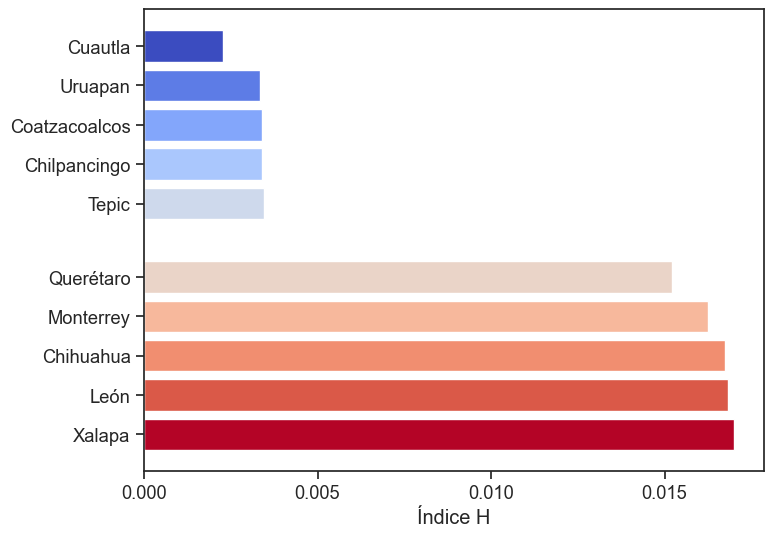

In [ ]:
sns.set_theme(style="ticks", font_scale=1.2)

cmap = plt.get_cmap("coolwarm", 10)
top_n = 5
spacing = 1.15
bar_width = 0.8 / spacing

df_plot = pd.concat([df.head(top_n), df.tail(top_n)])

fig, ax = plt.subplots(figsize=(8, 6))
x1 = np.array(range(top_n)) / spacing
x2 = np.array(range(top_n, 2 * top_n)) / spacing + (spacing - 1) * top_n

ax.barh(
    y=x1,
    width=df_plot.head(top_n),
    color=[cmap(i) for i in range(top_n)],
    height=bar_width,
)
ax.barh(
    y=x2,
    width=df_plot.tail(top_n),
    color=[cmap(i) for i in range(top_n, 2 * top_n)],
    height=bar_width,
)

ax.set_yticks(np.concatenate([x1, x2]))
ax.set_yticklabels(df_plot.index, rotation=0, ha="right")

ax.invert_yaxis()
ax.set_xlabel("Índice H")
ax.set_xticks(np.arange(0, 0.02, 0.005))
fig.savefig("out.png", bbox_inches="tight", dpi=300)